In [122]:
# %%
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# For inline plotting in Jupyter Notebook
%matplotlib inline


In [123]:
# %%
# Replace 'your_file.csv' with the path to your CSV file.
df = pd.read_csv('data_preprocessed_with_all_sectors.csv')
print("DataFrame Head:")
print(df.head())


DataFrame Head:
      Price  Price/Earnings  Dividend_Yield  Earnings/Share  52_Week_Low  \
0  0.878344       -0.008454        0.280215        0.743147     0.875014   
1 -0.324371        0.076259       -0.489462       -0.382941    -0.349252   
2 -0.353727       -0.052652        0.004876       -0.643643    -0.373496   
3  0.032340       -0.128771        0.388497       -0.095082     0.018386   
4  0.343130        0.020029       -0.121474        0.294160     0.253414   

   52_Week_High  Market_Cap    EBITDA  Price/Sales  Price/Book  ...  \
0      0.861718    0.986142  0.796009     0.125507   -0.035195  ...   
1     -0.327918   -0.425974 -0.432863    -0.108525   -0.090795  ...   
2     -0.390377    0.582168  0.315342    -0.061133   -0.126005  ...   
3     -0.223349    1.457061  0.979604     0.671617    0.129711  ...   
4      0.291456    0.545135  0.300682    -0.387530   -0.043217  ...   

   Sector_Consumer Staples  Sector_Energy  Sector_Financials  \
0                      0.0          

In [124]:
# %%
# Separate features and target (avoid leakage by dropping the target from features).
features = df.drop('Price', axis=1)
target = df['Price']

# Initialize scalers for features and target.
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale features.
features_scaled_array = feature_scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled_array, columns=features.columns)

# Scale target (reshaping is needed because the scaler expects a 2D array).
target_scaled_array = target_scaler.fit_transform(target.values.reshape(-1, 1))
target_scaled = pd.Series(target_scaled_array.flatten())

# Function to create sliding windows.
def create_windows(features, target, window_size):
    """
    Create sliding windows for the features and corresponding target values.
    
    Parameters:
      features (DataFrame): Scaled input features.
      target (Series): Scaled target variable.
      window_size (int): Number of consecutive days per sample.
      
    Returns:
      X: NumPy array of shape (num_samples, window_size, num_features)
      y: NumPy array of target values for each sample.
    """
    X = []
    y = []
    for i in range(len(features) - window_size):
        X.append(features.iloc[i:i+window_size].values)
        y.append(target.iloc[i+window_size])
    return np.array(X), np.array(y)

# Set window size to 10 days.
window_size = 10
X, y = create_windows(features_scaled, target_scaled, window_size)

print("Shape of input (X):", X.shape)  # Expected: (num_samples, 10, num_features)
print("Shape of target (y):", y.shape)


Shape of input (X): (485, 10, 20)
Shape of target (y): (485,)


In [125]:
# %%
# Split the data into training (80%) and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# Determine input dimensions.
n_timesteps = X_train.shape[1]  # Should be 10 (window size)
n_features = X_train.shape[2]   # Number of features


Training samples: 388
Testing samples: 97


In [126]:
# %%
# Set hyperparameters.
l2_lambda = 0.001      # L2 regularization strength
dropout_rate = 0.3     # Dropout rate (30%)
learning_rate = 0.001  # Learning rate

model = Sequential()

# --- Convolutional Block ---
# First Conv1D layer with 32 filters.
model.add(Conv1D(filters=32, 
                 kernel_size=2, 
                 activation='relu', 
                 padding='same', 
                 input_shape=(n_timesteps, n_features),
                 kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
# Second Conv1D layer.
model.add(Conv1D(filters=32, 
                 kernel_size=2, 
                 activation='relu', 
                 padding='same',
                 kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
# Downsample with max pooling.
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))

# --- LSTM Block ---
# LSTM layer to capture temporal dependencies.
model.add(LSTM(32, 
               activation='tanh', 
               return_sequences=False, 
               kernel_regularizer=l2(l2_lambda)))
model.add(Dropout(dropout_rate))

# --- Dense Block ---
# Additional Dense layer to increase capacity.
model.add(Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)))
model.add(Dropout(dropout_rate))

# Output layer for regression.
model.add(Dense(1, activation='linear'))

# Compile the model.
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

model.summary()


2025-02-11 22:42:49.093499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 22:42:49.094123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 22:42:49.094852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 10, 32)            1312      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_11 (Conv1D)          (None, 10, 32)            2080      
                                                                 
 batch_normalization_2 (Batc  (None, 10, 32)           128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 5, 32)            0         
 1D)                                                             
                                                     

In [127]:
# %%
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=100,            # Maximum epochs (training stops early if no improvement).
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/100


2025-02-11 22:42:49.287717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 22:42:49.288475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 22:42:49.289071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 2s 23ms/step - loss: 0.2152 - val_loss: 0.1473 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1791 - val_loss: 0.1413 - lr: 0.0010
Epoch 3/100
 1/13 [=>............................] - ETA: 0s - loss: 0.1683

2025-02-11 22:42:50.778228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 22:42:50.778719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 22:42:50.779177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 0s 5ms/step - loss: 0.1666 - val_loss: 0.1393 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1572 - val_loss: 0.1355 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1465 - val_loss: 0.1321 - lr: 0.0010
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1438 - val_loss: 0.1293 - lr: 0.0010
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.1381 - val_loss: 0.1270 - lr: 0.0010
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1343 - val_loss: 0.1253 - lr: 0.0010
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1310 - val_loss: 0.1240 - lr: 0.0010
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1264 - val_loss: 0.1227 - lr: 0.0010
Epoch 11/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1229 - val_loss: 0.1212 - lr: 0.0010
Ep

In [128]:
# %%
# Evaluate the model on the test set.
test_loss = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", test_loss)

# Generate predictions.
y_pred = model.predict(X_test)

# Invert scaling to get back to the original target scale.
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

# Calculate evaluation metrics.
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print("\nEvaluation Metrics on Test Set (Inverse Transformed):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


4/4 [==============================] - 0s 1ms/step - loss: 0.0114
Test Loss (MSE): 0.01140128169208765
4/4 [==============================] - 0s 1ms/step

Evaluation Metrics on Test Set (Inverse Transformed):
Mean Squared Error (MSE): 0.6045
Root Mean Squared Error (RMSE): 0.7775
Mean Absolute Error (MAE): 0.4806
R² Score: 0.1446


2025-02-11 22:42:56.930270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 22:42:56.931952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 22:42:56.937971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

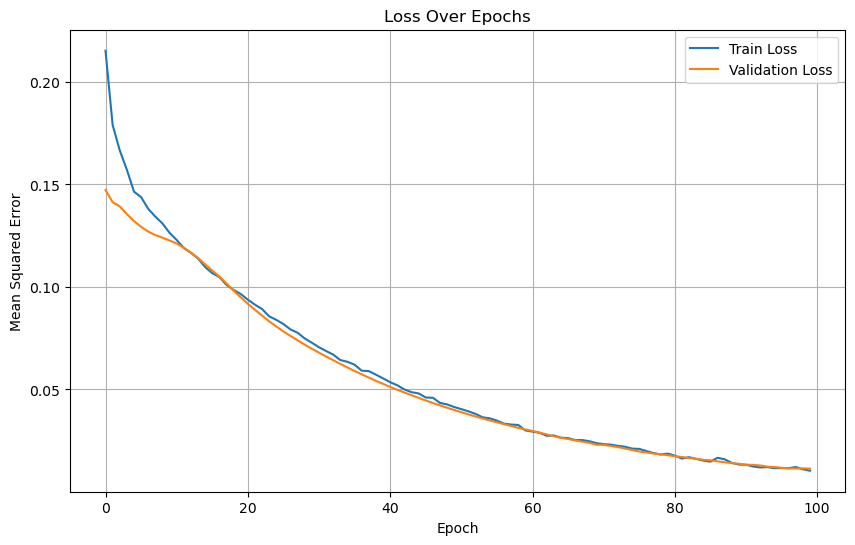

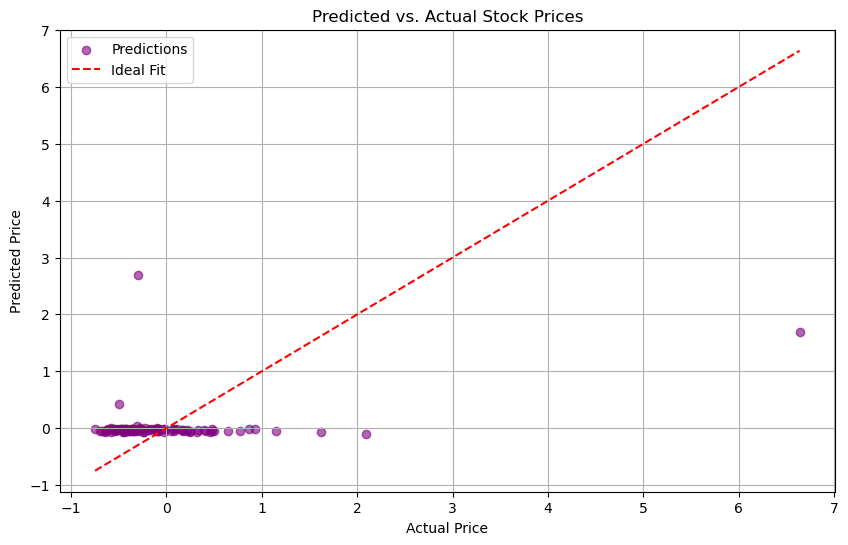

In [129]:
# %%
# Plot training and validation loss over epochs.
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot: Predicted vs. Actual values (inverse transformed).
plt.figure(figsize=(10, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.6, color='purple', label='Predictions')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs. Actual Stock Prices')
min_val = min(y_test_inv.min(), y_pred_inv.min())
max_val = max(y_test_inv.max(), y_pred_inv.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
plt.legend()
plt.grid(True)
plt.show()
